In [175]:
import pandas as pd
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import sklearn.metrics as metrics
import sklearn.utils as utils
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import tree
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz 
import math

In [265]:
files = os.listdir('../Data/rmsds')
first = True
data = pd.read_csv("../Data/rmsds/5HT2B_rmsds.csv")
for file in files:
    if file[-4:] == '.csv' and file != '5HT2B_rmsds.csv':
        fileData = pd.read_csv("../Data/rmsds/" + file)
        data = pd.concat([data, fileData], sort=False)
data = data[data['secondary structure'] != -1]
data = data[data['rmsd'] < 30]
prots = data['protein'].unique()

utils.shuffle(prots, random_state=7)

train_prots = prots[:len(prots) * 66 // 100]
test_prots = prots[len(prots) * 66 // 100:]

train_data = data[data['protein'].isin(train_prots)]
test_data = data[data['protein'].isin(test_prots)]
MAPK14_2YIX_3D83_data = data[(data['protein'] == 'MAPK14') & (data['start ligand'] == '2YIX') & (data['target ligand'] == '3D83')]

X_train = train_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'rmsd', 'normal variate bfactor',
                           'res name'], axis=1).values
Y_train = train_data['rmsd'].values 

X_test = test_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'rmsd', 'normal variate bfactor', 
                         'res name'], axis=1).values
Y_test = test_data['rmsd'].values 

no_ligand_X_train = train_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'ligand similarity', 'ligand similarity ratio', 'ligand size difference', 'ligand size ratio', 'rmsd', 'normal variate bfactor', 'res name'],
                          axis=1).values
no_ligand_X_test = test_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'ligand similarity', 'ligand similarity ratio', 'ligand size difference', 'ligand size ratio', 'rmsd', 'normal variate bfactor', 'res name'],
                        axis=1).values

MAPK14_2YIX_3D83_X_test = MAPK14_2YIX_3D83_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'rmsd', 'normal variate bfactor', 'res name'],
                          axis=1).values
MAPK14_2YIX_3D83_Y_test = MAPK14_2YIX_3D83_data['rmsd'].values 

X_true = X_train[Y_train > 2]
Y_true = Y_train[Y_train > 2]

no_ligand_X_true = no_ligand_X_train[Y_train > 2]

In [266]:
X_train_expanded_50 = np.append(X_train, X_true, axis=0)
no_ligand_X_train_expanded_50 = np.append(no_ligand_X_train, no_ligand_X_true, axis=0)
Y_train_expanded_50 = np.append(Y_train, Y_true, axis=0)

for i in range(4):
    X_train_expanded_50 = np.append(X_train_expanded_50, X_true, axis=0)
    no_ligand_X_train_expanded_50 = np.append(no_ligand_X_train_expanded_50, no_ligand_X_true, axis=0)
    Y_train_expanded_50 = np.append(Y_train_expanded_50, Y_true, axis=0)
    
print('Ratio of positive examples (50)', np.sum(Y_train_expanded_50 > 2)/len(Y_train_expanded_50))

Ratio of positive examples (50) 0.4674280935143682


In [242]:
dict_classifiers = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression": LinearRegression(),
#     "Neural Network": MLPRegressor(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500),
    "Decision Tree": DecisionTreeRegressor(random_state = 0),
    "Decision Tree with Max Depth = 03": DecisionTreeRegressor(max_depth=3, random_state = 0),
    "Decision Tree with Max Depth = 05": DecisionTreeRegressor(max_depth=5, random_state = 0),
    "Decision Tree with Max Depth = 10": DecisionTreeRegressor(max_depth=10, random_state = 0),
    "Decision Tree with Max Depth = 15": DecisionTreeRegressor(max_depth=15, random_state = 0),
#     "Random Forest": RandomForestRegressor(n_estimators=100, random_state=0)
}

In [189]:
def batch_classify(X_train, Y_train, X_test, Y_test, verbose=True, include_y_pred=False):
    """
    This method, takes as input the X, Y matrices of the Train and Test set.
    And fits them on all of the Classifiers specified in the dict_classifier.
    The trained models, and accuracies are saved in a dictionary. The reason to use a dictionary
    is because it is very easy to save the whole dictionary with the pickle module.

    Usually, the SVM, Random Forest and Gradient Boosting Classifier take quiet some time to train.
    So it is best to train them on a smaller dataset first and
    decide whether you want to comment them out or not based on the test accuracy score.
    """

    dict_models = {}
    for classifier_name, classifier in list(dict_classifiers.items()):
        coefs = None
        if classifier_name == "Polynomial Regression":
            poly = PolynomialFeatures(degree=2)
            saved_X_train = X_train
            saved_X_test = X_test
            X_train = poly.fit_transform(X_train)
            X_test = poly.fit_transform(X_test)
        if classifier_name == "Random Forest":
            sc = StandardScaler()
            X_train = sc.fit_transform(X_train)
            X_test = sc.transform(X_test)
        t_start = time.process_time()
        classifier.fit(X_train, Y_train)
        t_end = time.process_time()
        
        if 'Decision Tree' in classifier_name:
            print()

        if classifier_name == "Linear Regression":
            coefs = classifier.coef_
        
        t_diff = t_end - t_start
        train_score = classifier.score(X_train, Y_train)
        Y_pred = classifier.predict(X_test)
        test_score = classifier.score(X_test, Y_test)

        if include_y_pred:
            dict_models[classifier_name] = {'model': classifier_name, 'train_score': train_score,
                                            'test_score': test_score, 'train_time': t_diff, 'y_pred': Y_pred}
        else:
            dict_models[classifier_name] = {'model': classifier_name, 'train_score': train_score,
                                            'test_score': test_score, 'train_time': t_diff, 'coef':coefs}
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=classifier_name, f=t_diff))
        if classifier_name == "Polynomial Regression":
            X_train = saved_X_train
            X_test = saved_X_test
    return dict_models

In [272]:
expand_dict_models = batch_classify(X_train_expanded_50, Y_train_expanded_50, X_test, Y_test, include_y_pred=True)
pd.DataFrame.from_dict(expand_dict_models, orient='index')

trained Linear Regression in 1.28 s
trained Polynomial Regression in 10.91 s

trained Decision Tree in 6.30 s

trained Decision Tree with Max Depth = 03 in 2.34 s

trained Decision Tree with Max Depth = 05 in 3.14 s

trained Decision Tree with Max Depth = 10 in 4.09 s

trained Decision Tree with Max Depth = 15 in 4.83 s


,model,train_score,test_score,train_time,y_pred
Decision Tree,Decision Tree,0.989410,-1.628875,6.301780,"[2.1987491272099997, 10.037038842100001, 1.363..."
Decision Tree with Max Depth = 03,Decision Tree with Max Depth = 03,0.181206,-0.432818,2.335826,"[3.314902856451116, 3.314902856451116, 3.31490..."
Decision Tree with Max Depth = 05,Decision Tree with Max Depth = 05,0.273165,-0.487480,3.138016,"[4.0731156102894674, 4.0731156102894674, 1.682..."
Decision Tree with Max Depth = 10,Decision Tree with Max Depth = 10,0.614484,-0.922312,4.085112,"[4.072324150169668, 3.9238091575725833, 0.9523..."
Decision Tree with Max Depth = 15,Decision Tree with Max Depth = 15,0.860057,-1.452680,4.833102,"[3.5190601509468724, 10.037038842100001, 1.274..."
Linear Regression,Linear Regression,0.184748,-0.350483,1.278424,"[4.6287757919971675, 4.543195841209904, 2.1475..."
Polynomial Regression,Polynomial Regression,0.243611,-0.347631,10.914480,"[6.136496206734693, 4.371498974006559, 1.89806..."


In [274]:
print(data.columns[5:18])
dict_classifiers['Linear Regression'].coef_

Index(['bfactor', 'normalized bfactor', 'prev prev bfactor', 'prev bfactor',
       'next bfactor', 'next next bfactor', 'mol weight',
       'solvent accessibility', 'secondary structure', 'ligand similarity',
       'ligand similarity ratio', 'ligand size difference',
       'ligand size ratio'],
      dtype='object')


array([ 0.01781596,  0.18236531,  0.01101002,  0.22762353,  0.0446577 ,
        0.20149002,  0.00081155,  0.00905314, -0.34410827, -0.03606765,
       -0.15984297,  0.00632514, -0.05359373])

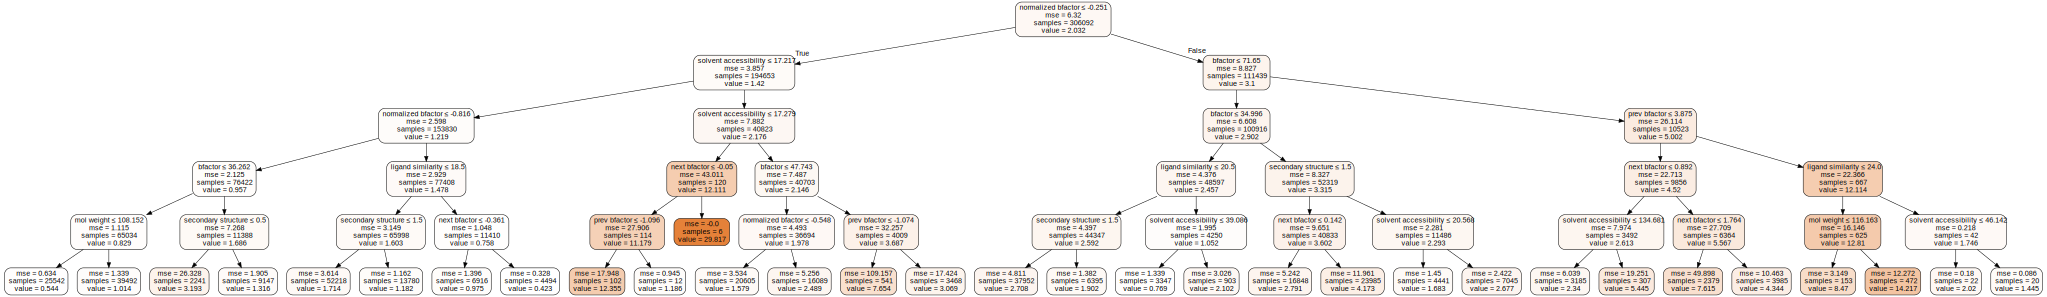

In [132]:
dot_data = tree.export_graphviz(dict_classifiers['Decision Tree with Max Depth = 05'], out_file=None, feature_names=data.columns[5:13], filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)
graph

In [270]:
print(data.columns[5:13])
dict_classifiers['Decision Tree with Max Depth = 05'].feature_importances_

Index(['bfactor', 'normalized bfactor', 'prev prev bfactor', 'prev bfactor',
       'next bfactor', 'next next bfactor', 'mol weight',
       'solvent accessibility'],
      dtype='object')


array([0.16059859, 0.41591425, 0.        , 0.07610623, 0.        ,
       0.14311448, 0.02861732, 0.13420632, 0.04144282])

In [267]:
no_ligand_expand_dict_models = batch_classify(no_ligand_X_train_expanded_50, Y_train_expanded_50, no_ligand_X_test, Y_test, include_y_pred=True)
pd.DataFrame.from_dict(no_ligand_expand_dict_models, orient='index')

trained Linear Regression in 0.77 s
trained Polynomial Regression in 5.74 s

trained Decision Tree in 3.59 s

trained Decision Tree with Max Depth = 03 in 2.17 s

trained Decision Tree with Max Depth = 05 in 2.53 s

trained Decision Tree with Max Depth = 10 in 2.95 s

trained Decision Tree with Max Depth = 15 in 3.23 s


,model,train_score,test_score,train_time,y_pred
Decision Tree,Decision Tree,0.866518,-1.714306,3.592354,"[3.4965163497565994, 10.037038842100001, 0.963..."
Decision Tree with Max Depth = 03,Decision Tree with Max Depth = 03,0.181206,-0.432818,2.168500,"[3.3149028564511025, 3.3149028564511025, 3.314..."
Decision Tree with Max Depth = 05,Decision Tree with Max Depth = 05,0.270914,-0.482661,2.525196,"[4.073115610289444, 4.073115610289444, 1.68281..."
Decision Tree with Max Depth = 10,Decision Tree with Max Depth = 10,0.615464,-0.926820,2.953148,"[3.963492849563862, 3.9238091575725833, 1.0775..."
Decision Tree with Max Depth = 15,Decision Tree with Max Depth = 15,0.810412,-1.715585,3.232704,"[2.813954853132087, 10.037038842100001, 0.9422..."
Linear Regression,Linear Regression,0.172111,-0.322445,0.774988,"[4.57005966162161, 4.453672994515975, 2.043212..."
Polynomial Regression,Polynomial Regression,0.221661,-0.384818,5.739012,"[6.1827126429308725, 4.410666741782388, 1.8710..."


In [86]:
MAPK14_2YIX_3D83_dict_models = batch_classify(X_train_expanded_50, Y_train_expanded_50, MAPK14_2YIX_3D83_X_test, MAPK14_2YIX_3D83_Y_test, include_y_pred=True)

trained Linear Regression in 0.92 s
trained Polynomial Regression in 4.45 s
trained Decision Tree in 15.55 s
trained Decision Tree with Max Depth = 03 in 5.66 s
trained Decision Tree with Max Depth = 05 in 7.55 s
trained Decision Tree with Max Depth = 10 in 11.02 s
trained Decision Tree with Max Depth = 15 in 13.12 s


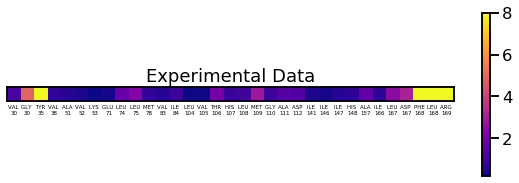

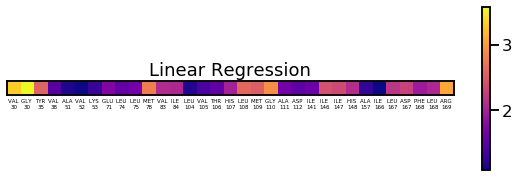

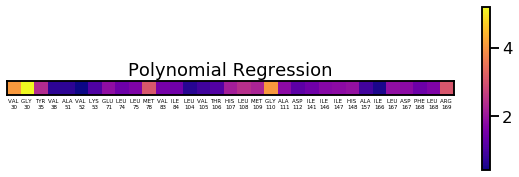

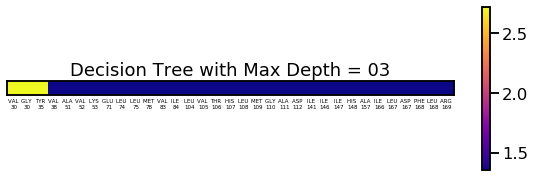

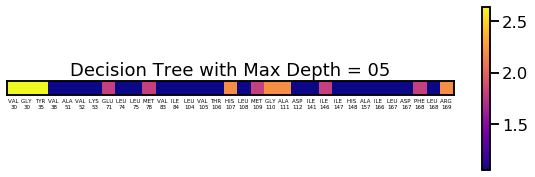

In [66]:
selected = MAPK14_2YIX_3D83_data.loc[(MAPK14_2YIX_3D83_data['start ligand'] == '2YIX') & (MAPK14_2YIX_3D83_data['target ligand'] == '3D83')]
rmsd = np.array(selected['rmsd'])
rmsd[rmsd > 8] = 8
rmsd_formatted = np.expand_dims(rmsd, axis=0)
sns.set_context("talk", font_scale=1.0)

plt.imshow(rmsd_formatted, cmap="plasma", interpolation='none')

fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Experimental Data')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(MAPK14_2YIX_3D83_dict_models['Linear Regression']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Linear Regression')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(MAPK14_2YIX_3D83_dict_models['Polynomial Regression']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Polynomial Regression')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(MAPK14_2YIX_3D83_dict_models['Decision Tree with Max Depth = 03']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Decision Tree with Max Depth = 03')
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(MAPK14_2YIX_3D83_dict_models['Decision Tree with Max Depth = 05']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

plt.colorbar()
plt.title('Decision Tree with Max Depth = 05')
plt.show()

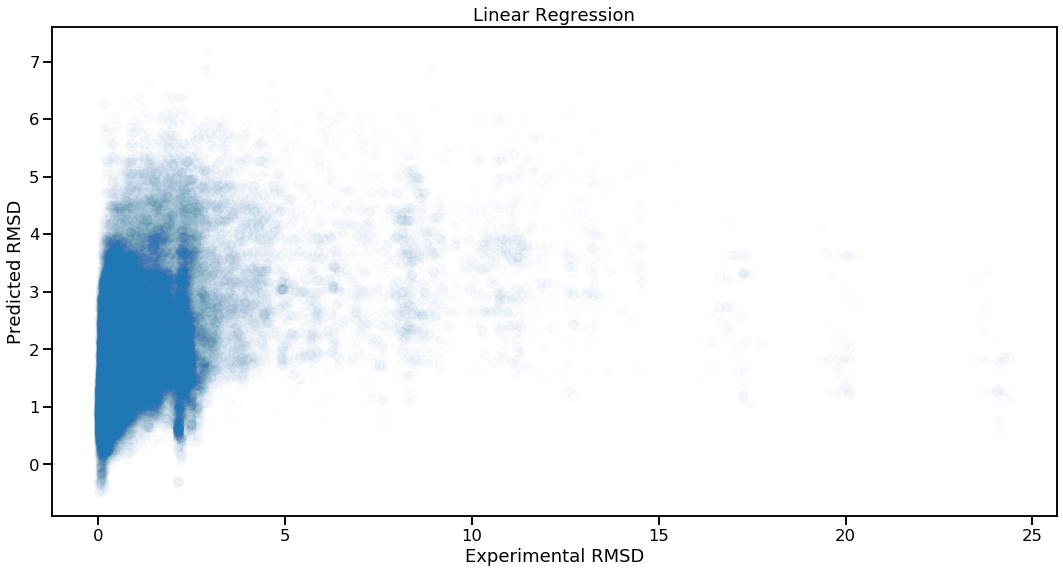

In [83]:
plt.scatter(Y_test, expand_dict_models['Linear Regression']['y_pred'], alpha=0.01)   
plt.title('Linear Regression')
plt.xlabel('Experimental RMSD')
plt.ylabel('Predicted RMSD')
#plt.xlim(0, 30)
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 12 and height to 9
fig_size[0] = 18
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
plt.show()

In [103]:
def scores_calculator(classifiers, dict_models):
    score_dict = {}
    for classifier in classifiers:
        Y_pred_bin = dict_models[classifier]['y_pred'] > 2
        Y_test_bin = Y_test > 2
        true_pos_count = 0
        true_neg_count = 0
        false_pos_count = 0
        false_neg_count = 0
        for i in range(len(Y_pred_bin)):
            if Y_pred_bin[i] == Y_test_bin[i]:
                if Y_pred_bin[i] == True:
                    true_pos_count += 1
                else:
                    true_neg_count += 1
            else:
                if Y_pred_bin[i] == True:
                    false_pos_count += 1
                else:
                    false_neg_count += 1
                    
        score_dict[classifier] = {'Accuracy':(true_pos_count + true_neg_count) / len(Y_pred_bin), 
                                 'Recall':true_pos_count / (true_pos_count + false_neg_count),
                                 'Precision':true_pos_count / (true_pos_count + false_pos_count)}
        
    return score_dict

In [268]:
all_classifiers_scores = scores_calculator(list(dict_classifiers.keys()), expand_dict_models)
pd.DataFrame.from_dict(all_classifiers_scores, orient='index')

,Accuracy,Recall,Precision
Decision Tree,0.789543,0.288417,0.236068
Decision Tree with Max Depth = 03,0.593831,0.734667,0.201615
Decision Tree with Max Depth = 05,0.666834,0.655917,0.224950
Decision Tree with Max Depth = 10,0.724185,0.549000,0.243594
Decision Tree with Max Depth = 15,0.771257,0.472750,0.272740
Linear Regression,0.620433,0.706167,0.208987
Polynomial Regression,0.646544,0.709750,0.223046


In [269]:
all_classifiers_scores = scores_calculator(list(dict_classifiers.keys()), no_ligand_expand_dict_models)
pd.DataFrame.from_dict(all_classifiers_scores, orient='index')

,Accuracy,Recall,Precision
Decision Tree,0.761651,0.417167,0.245790
Decision Tree with Max Depth = 03,0.593831,0.734667,0.201615
Decision Tree with Max Depth = 05,0.667122,0.645500,0.223144
Decision Tree with Max Depth = 10,0.715165,0.582500,0.243596
Decision Tree with Max Depth = 15,0.761267,0.483167,0.263701
Linear Regression,0.636330,0.701583,0.216166
Polynomial Regression,0.657334,0.703750,0.228064
